# Searching for QPPs with GPs for the ISSI Team

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit, minimize

import celerite
from celerite import terms
import emcee

from glob import glob
from astropy.io import fits

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [4]:
files = glob('../flares/*.fits')

In [5]:
def aflare1(t, tpeak, fwhm, ampl):
    '''
    The Analytic Flare Model evaluated for a single-peak (classical).
    Reference Davenport et al. (2014) http://arxiv.org/abs/1411.3723

    Use this function for fitting classical flares with most curve_fit
    tools.

    Note: this model assumes the flux before the flare is zero centered

    Parameters
    ----------
    t : 1-d array
        The time array to evaluate the flare over
    tpeak : float
        The time of the flare peak
    fwhm : float
        The "Full Width at Half Maximum", timescale of the flare
    ampl : float
        The amplitude of the flare

    Returns
    -------
    flare : 1-d array
        The flux of the flare model evaluated at each time
    '''
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]

    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

In [6]:
# the liklihood fnction we'll need for the GP....
def neg_log_like(params, ynew, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(ynew)

In [7]:
def combined_log_prob(params, x, y, yerr):
    '''
    fit BOTH the flare + the QPP/GP
    params are: (tpeak, fwhm, ampl, SHO1,SHO2,SHO3)
    '''
    flare_model = aflare1(x, params[0], params[1], params[2])
    flare_lnlike = -0.5*(np.sum((y-flare_model)**2.0 / yerr**2.0)) # under-estimated probably...
    
    # establish flare decay portion to evaluate the GP
    decay = np.where((x >= params[0]) & (x <= params[0] + 5*params[1]))
    # need an error catch here if decay is empty...
    
    try: 
        gp.set_parameter_vector(params[3:])
        gp_lnlike = gp.log_likelihood(y[decay])
    except (ValueError):
        gp_lnlike = -np.inf

    return flare_lnlike + gp_lnlike

/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


0: Recovered Period = 133.922645715 minutes


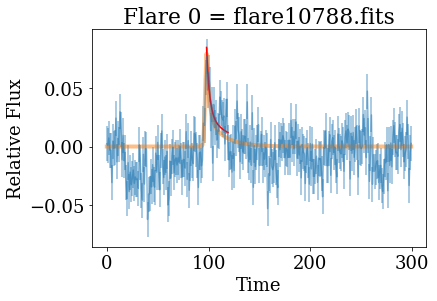

1: Suspect period =0.0193371011207


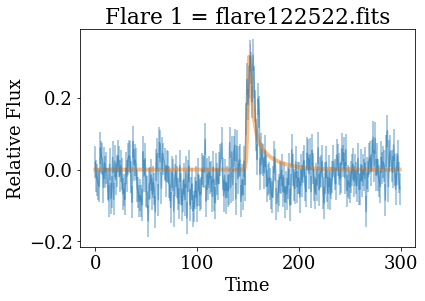

2: Suspect period =183782.028253


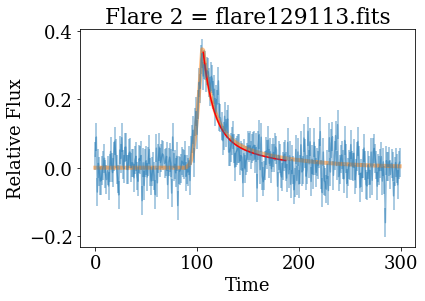

3: Recovered Period = 27.7704898217 minutes


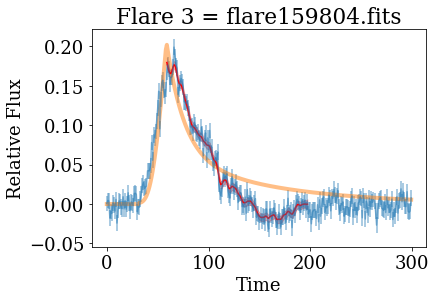

4: Suspect period =531.773563236


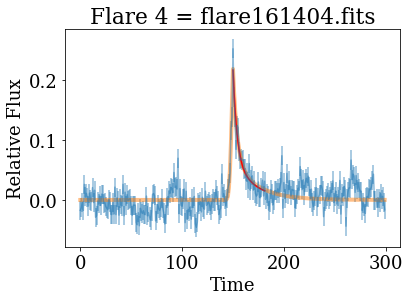

5: Recovered Period = 36.2306131133 minutes


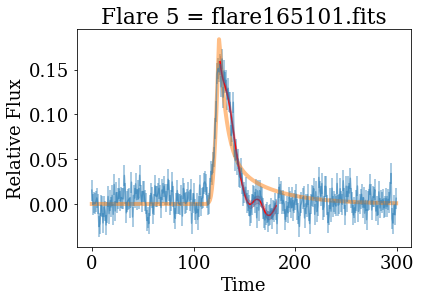

6: Suspect period =114510.695679


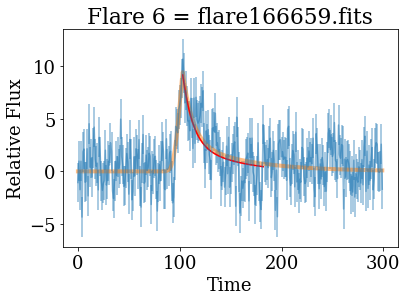

7: Recovered Period = 6.82195317104 minutes


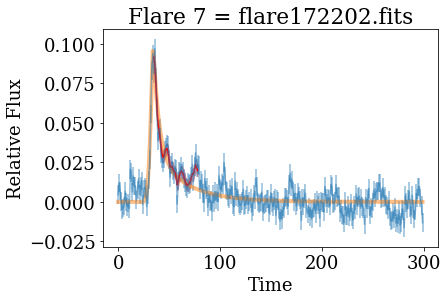

8: Recovered Period = 29.7086653852 minutes


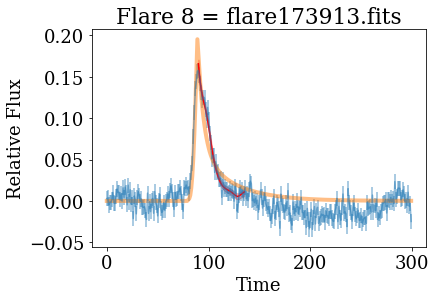

9: Recovered Period = 35.9895479703 minutes


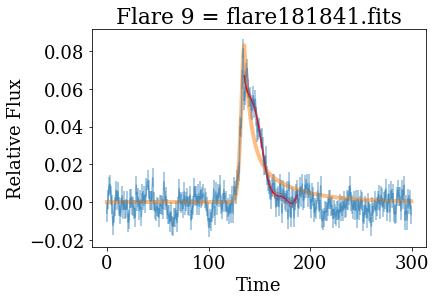

10: Recovered Period = 18.9904868261 minutes


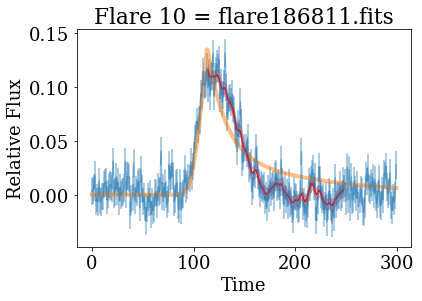

11: Suspect period =54183.9265836
12: Recovered Period = 18.6329780902 minutes
13: Recovered Period = 5.61843755999 minutes
14: Suspect period =0.141371556603
15: Recovered Period = 42.9406107681 minutes
16: Recovered Period = 17.3165181143 minutes
17: Suspect period =20539841.9236
18: Suspect period =20539841.9236
19: Recovered Period = 6.08597217203 minutes
20: Recovered Period = 27.809241151 minutes
21: Suspect period =499.551196404
22: Recovered Period = 19.2983313766 minutes
23: Recovered Period = 51.8481047275 minutes
24: Recovered Period = 139.509258926 minutes
25: BAD/NO PERIOD (GP ERROR)


/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: overflow encountered in exp
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log


26: Recovered Period = 178.381173394 minutes
27: Suspect period =486.522428645
28: Recovered Period = 31.9671454225 minutes
29: Suspect period =286.232620703
30: Recovered Period = 10.3607380283 minutes
31: Suspect period =2.22644565391
32: Suspect period =272.847634862
33: Suspect period =20539841.9236
34: Recovered Period = 21.5138206535 minutes
35: Recovered Period = 22.5573344748 minutes
36: Recovered Period = 32.7226654963 minutes
37: Suspect period =104421.344025
38: Recovered Period = 56.2482551813 minutes
39: Recovered Period = 29.3576844218 minutes
40: Recovered Period = 24.6834328069 minutes
41: Suspect period =1417.45536351
42: Recovered Period = 12.3459306887 minutes
43: Recovered Period = 100.106402754 minutes
44: Suspect period =647.554389214
45: Recovered Period = 89.1307670832 minutes
46: Suspect period =20539841.9236
47: Suspect period =5009.17050891
48: Recovered Period = 12.9548485698 minutes
49: Suspect period =0.153853882269
50: Recovered Period = 11.7363035317 min

/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/Users/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/james/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


71: BAD/NO PERIOD (GP ERROR)
72: Recovered Period = 37.585189071 minutes
73: Recovered Period = 8.37691857193 minutes
74: Recovered Period = 5.44270264216 minutes
75: Suspect period =249.406291389
76: Suspect period =0.212689270478
77: Suspect period =9843.92356102
78: Suspect period =5558840.33776
79: Suspect period =40325.5842393
80: Recovered Period = 53.6870295497 minutes
81: Suspect period =482.708533281
82: Suspect period =479.501349539
83: Suspect period =57320.0666154
84: Recovered Period = 87.5912384111 minutes
85: Suspect period =242.180405325
86: Recovered Period = 37.5061920948 minutes
87: Suspect period =12042716.1786
88: Recovered Period = 13.0616742277 minutes
89: Recovered Period = 36.4450446162 minutes
90: Suspect period =348.548994568
91: Recovered Period = 34.065793039 minutes
92: Suspect period =269.050739723
93: Recovered Period = 25.8746838504 minutes
94: Suspect period =20539841.9236
95: Suspect period =166874.913691
96: Recovered Period = 31.4294403621 minutes
9

In [8]:
period_out = np.zeros(len(files))
period_flag = np.zeros(len(files))
file_out = np.array(files, dtype=np.str)

for k in range(len(files)): 

    hdu = fits.open(files[k])
    data = hdu[1].data
    hdu.close()

    time = data.field(0)
    
    medflux = np.nanmedian(data.field(1))
    
    # detrend any underlying shape... (this is frought with danger)
    # we shall assume:
    # A) the flare is not in the first or last 10 data points
    # B) a linear polynomial is enough (for now)
    
    c1 = np.nanmedian(data.field(1)[0:10])
    c2 = np.nanmedian(data.field(1)[-10:])
    t1 = np.nanmedian(data.field(0)[0:10])
    t2 = np.nanmedian(data.field(0)[-10:])

    slope = (c2 - c1) / (t2 - t1)
    inter = c2 - slope*t2
    
    flux = (data.field(1) - (slope * time + inter)) / medflux
    
    # find the typical (median) scatter in small chunks of the light curve 
    # (11 data points, arbitrarily chosen) to use as the error
    std = np.nanmedian(pd.rolling_std(flux, 11))
    err = np.ones(time.size) * std
    
    
    # get approximate properties of flare
    ampl = np.nanmax(flux)
    f05 = np.where((flux >= ampl*0.5))
    fwhm = np.nanmax(time[f05]) - np.nanmin(time[f05])
    p0 = [time[np.argmax(flux)], fwhm, ampl]
    
    popt, pcov = curve_fit(aflare1, time, flux, p0=p0)
    
    
    # the decay region:
    # do from PEAK to 5X the FWHM timescale (i.e. don't fit the out-of-flare region)
    decay = np.where((time >= popt[0]) & (time <= popt[0] + 5*popt[1]))
    
    #__ do the GP __
    tresid = time[decay]
    eresid = err[decay]
    fresid = flux[decay] - aflare1(time[decay], *popt)

    # DO WE TRUST ALL THESE KERNEL PARAMETERS????
    # Celerite SHO Kernel:
    Q = 1.0
    w0 = 3.0
    S0 = np.var(fresid) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))

    
    # draw the figure... put around the GP (annoyingly)
    plt.figure()
    plt.errorbar(time, flux, yerr=err, alpha=0.5)
    plt.plot(time, aflare1(time, *popt), alpha=0.5, lw=4)
    
    
    # wrap GP in Try/Except to catch some value error problem I don't understand
    try: 
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                bounds=bounds)

        gp = celerite.GP(kernel, mean=np.mean(fresid))
        gp.compute(tresid, eresid)

        initial_params = gp.get_parameter_vector()
        bounds = gp.get_parameter_bounds()
        r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(fresid, gp))
        gp.set_parameter_vector(r.x)
        pred_mean, pred_var = gp.predict(fresid, tresid, return_var=True)
        pred_std = np.sqrt(pred_var)

    
        color = 'red'
        plt.plot(tresid, pred_mean + aflare1(tresid, *popt), color=color,label="GP") # GP fit
        plt.fill_between(tresid, pred_mean + pred_std + aflare1(tresid, *popt), 
                         pred_mean - pred_std + aflare1(tresid, *popt), 
                         color=color, alpha=0.3, edgecolor="none") # Standard deviation boundaries
        
        omega_0 = np.exp(gp.kernel.terms[0][2])
        period = (2*np.pi) / omega_0

        
        if (period < 200) & (period > 3):
            print(str(k) + ": Recovered Period = " + str(period) + " minutes")
            period_out[k] = period
            period_flag[k] = 0


        else:
            print(str(k) + ': Suspect period =' + str(period))
            period_out[k] = period
            period_flag[k] = 1

        
    except ValueError:
        print(str(k) + ': BAD/NO PERIOD (GP ERROR)')
        period_out[k] = -1
        period_flag[k] = 1



    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.title('Flare '+str(k)+' = ' + files[k][10:])
    plt.savefig('../figures/' + files[k][10:-5] + '.png', dpi=150, bbox_inches='tight', pad_inches=0.25)
    if k < 11:
        plt.show()
    else:
        plt.close()
    
    file_out[k] = files[k][10:-5]
    
    
    '''
    ### MCMC (step 4) not currently working
    # now fit w/ MCMC together
    initial = np.array([*popt, *r.x])
    ndim, nwalkers = len(initial), 32
    sampler = emcee.EnsembleSampler(nwalkers, ndim, combined_log_prob, args=[time, flux, err])
    
    p0mcmc = initial + 1e-8*np.random.randn(nwalkers, ndim)
    p0mcmc, ln, _ = sampler.run_mcmc(p0mcmc, 500) # 500step burn-in
#     sampler.reset()
#     sampler.run_mcmc(p0mcmc, 2000) # 2000 step MCMC run
    ''';

    # To do inside loop (for each flare):
    # 1x) find flare peak
    # 2x) fit Davenport'14 flare model
    # 3x) fit GP on decay phase (residual)
    # 4) TRY: fit flare model + GP simultaneously w/ MCMC
    # 5x) make plot(s), produce table(s)



In [9]:
dfout = pd.DataFrame(data={'file':file_out, 'period':period_out, 'flag':period_flag})

In [10]:
dfout.to_csv('HH2_GP_output_v0.1.csv')